In [21]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import VoxelGrid
import os

from pyvox.models import Vox, Color
from pyvox.writer import VoxWriter
from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'

N_points=200

In [2]:
focal, all_c2w, all_gt = get_data("../lego")

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.95it/s]


In [3]:
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
im_w = target_ims[0].shape[0]
print(im_w)

red = 2
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

100
400


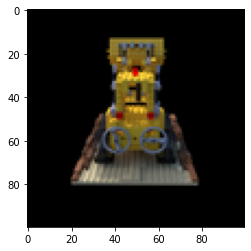

In [25]:
plt.imshow(target_ims[0])
plt.show()

In [26]:
test_focal, test_c2w, test_gt = get_data("../lego", "test")

LOAD DATA ../lego/test


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 53.89it/s]


In [27]:
red = 4
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims[0].shape[0]

In [28]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


In [55]:
VG = VoxelGrid(32, 1.2)
VG.load('32_good.obj')
VG.subdivide()

#plt.imshow(VG.render_image_from_rays(disp_rays[10],(500, 1.2)))

In [37]:
new_im = VG.render_image_from_rays(disp_rays[10],(500, 1.2))

In [45]:
losses=[]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

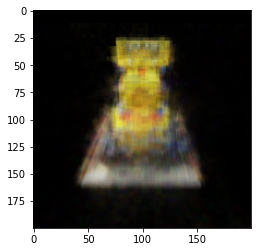

Train Epoch: 0 [0/200 (0%)]	Loss: 0.030539
Train Epoch: 0 [10/200 (5%)]	Loss: 0.030126
Train Epoch: 0 [20/200 (10%)]	Loss: 0.028658
Train Epoch: 0 [30/200 (15%)]	Loss: 0.028948
Train Epoch: 0 [40/200 (20%)]	Loss: 0.028825
Train Epoch: 0 [50/200 (25%)]	Loss: 0.030851
Train Epoch: 0 [60/200 (30%)]	Loss: 0.028722
Train Epoch: 0 [70/200 (35%)]	Loss: 0.029832
Train Epoch: 0 [80/200 (40%)]	Loss: 0.029568
Train Epoch: 0 [90/200 (45%)]	Loss: 0.029975
Train Epoch: 0 [100/200 (50%)]	Loss: 0.030053
Train Epoch: 0 [110/200 (55%)]	Loss: 0.031937
Train Epoch: 0 [120/200 (60%)]	Loss: 0.029184
Train Epoch: 0 [130/200 (65%)]	Loss: 0.028018
Train Epoch: 0 [140/200 (70%)]	Loss: 0.032244
Train Epoch: 0 [150/200 (75%)]	Loss: 0.029209
Train Epoch: 0 [160/200 (80%)]	Loss: 0.029750
Train Epoch: 0 [170/200 (85%)]	Loss: 0.029280
Train Epoch: 0 [180/200 (90%)]	Loss: 0.030949
Train Epoch: 0 [190/200 (95%)]	Loss: 0.028918


 25%|███████████                                 | 1/4 [02:07<06:23, 127.95s/it]

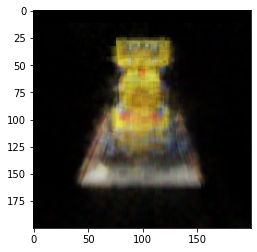

Train Epoch: 1 [0/200 (0%)]	Loss: 0.029153
Train Epoch: 1 [10/200 (5%)]	Loss: 0.030781
Train Epoch: 1 [20/200 (10%)]	Loss: 0.028635
Train Epoch: 1 [30/200 (15%)]	Loss: 0.030785
Train Epoch: 1 [40/200 (20%)]	Loss: 0.028152
Train Epoch: 1 [50/200 (25%)]	Loss: 0.028147
Train Epoch: 1 [60/200 (30%)]	Loss: 0.028554
Train Epoch: 1 [70/200 (35%)]	Loss: 0.030884
Train Epoch: 1 [80/200 (40%)]	Loss: 0.029836
Train Epoch: 1 [90/200 (45%)]	Loss: 0.030236
Train Epoch: 1 [100/200 (50%)]	Loss: 0.028294
Train Epoch: 1 [110/200 (55%)]	Loss: 0.029382
Train Epoch: 1 [120/200 (60%)]	Loss: 0.029615
Train Epoch: 1 [130/200 (65%)]	Loss: 0.029200
Train Epoch: 1 [140/200 (70%)]	Loss: 0.030356
Train Epoch: 1 [150/200 (75%)]	Loss: 0.031453
Train Epoch: 1 [160/200 (80%)]	Loss: 0.029634
Train Epoch: 1 [170/200 (85%)]	Loss: 0.030278
Train Epoch: 1 [180/200 (90%)]	Loss: 0.029889
Train Epoch: 1 [190/200 (95%)]	Loss: 0.028521


 50%|██████████████████████                      | 2/4 [04:16<04:16, 128.17s/it]

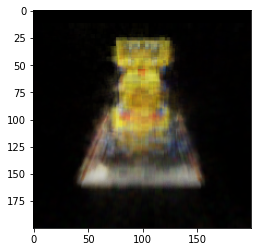

Train Epoch: 2 [0/200 (0%)]	Loss: 0.026704
Train Epoch: 2 [10/200 (5%)]	Loss: 0.029004
Train Epoch: 2 [20/200 (10%)]	Loss: 0.030104
Train Epoch: 2 [30/200 (15%)]	Loss: 0.030004
Train Epoch: 2 [40/200 (20%)]	Loss: 0.031032
Train Epoch: 2 [50/200 (25%)]	Loss: 0.031100
Train Epoch: 2 [60/200 (30%)]	Loss: 0.028709
Train Epoch: 2 [70/200 (35%)]	Loss: 0.029532
Train Epoch: 2 [80/200 (40%)]	Loss: 0.029919
Train Epoch: 2 [90/200 (45%)]	Loss: 0.028271
Train Epoch: 2 [100/200 (50%)]	Loss: 0.027655
Train Epoch: 2 [110/200 (55%)]	Loss: 0.030080
Train Epoch: 2 [120/200 (60%)]	Loss: 0.028065
Train Epoch: 2 [130/200 (65%)]	Loss: 0.028992
Train Epoch: 2 [140/200 (70%)]	Loss: 0.027530
Train Epoch: 2 [150/200 (75%)]	Loss: 0.027713
Train Epoch: 2 [160/200 (80%)]	Loss: 0.031272
Train Epoch: 2 [170/200 (85%)]	Loss: 0.029055
Train Epoch: 2 [180/200 (90%)]	Loss: 0.029254
Train Epoch: 2 [190/200 (95%)]	Loss: 0.030416


 75%|█████████████████████████████████           | 3/4 [06:24<02:08, 128.24s/it]

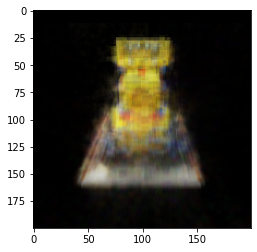

Train Epoch: 3 [0/200 (0%)]	Loss: 0.027392
Train Epoch: 3 [10/200 (5%)]	Loss: 0.027829
Train Epoch: 3 [20/200 (10%)]	Loss: 0.028597
Train Epoch: 3 [30/200 (15%)]	Loss: 0.028007
Train Epoch: 3 [40/200 (20%)]	Loss: 0.028042
Train Epoch: 3 [50/200 (25%)]	Loss: 0.028258
Train Epoch: 3 [60/200 (30%)]	Loss: 0.028676
Train Epoch: 3 [70/200 (35%)]	Loss: 0.029301
Train Epoch: 3 [80/200 (40%)]	Loss: 0.027850
Train Epoch: 3 [90/200 (45%)]	Loss: 0.029435
Train Epoch: 3 [100/200 (50%)]	Loss: 0.028042
Train Epoch: 3 [110/200 (55%)]	Loss: 0.028007
Train Epoch: 3 [120/200 (60%)]	Loss: 0.028551
Train Epoch: 3 [130/200 (65%)]	Loss: 0.028361
Train Epoch: 3 [140/200 (70%)]	Loss: 0.027073
Train Epoch: 3 [150/200 (75%)]	Loss: 0.027540
Train Epoch: 3 [160/200 (80%)]	Loss: 0.028558
Train Epoch: 3 [170/200 (85%)]	Loss: 0.028016
Train Epoch: 3 [180/200 (90%)]	Loss: 0.027538
Train Epoch: 3 [190/200 (95%)]	Loss: 0.028931


100%|████████████████████████████████████████████| 4/4 [08:32<00:00, 128.25s/it]


In [61]:
N_points=200
def train(epoch):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        pix_estims = VG.render_rays(rays, (N_points))
        
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] +0.0001*VG.total_variation()
        #loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0]
        loss.backward()
        losses.append(loss.item())
        VG.update_grads(1000)
        if batch_idx%10==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    )
                )
    return losses

for epoch in tqdm(range(4)):
    new_im = VG.render_image_from_rays(disp_rays[0],(1000,1.2))
    #VG.treshold_opacity(0.2)
    plt.imshow(new_im)
    plt.show()
    #plt.imsave('screenshots/a'+str(epoch)+'.png', new_im)



    losses += train(epoch)
    #VG.save('80_'+str(epoch)+'.obj')
    
    

Text(0.5, 0, 'Iterations')

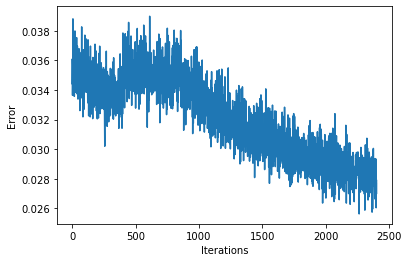

In [62]:
plt.plot((np.array(losses)))




plt.ylabel("Error")
plt.xlabel("Iterations")
#plt.savefig('exports/2epochs_32.png')

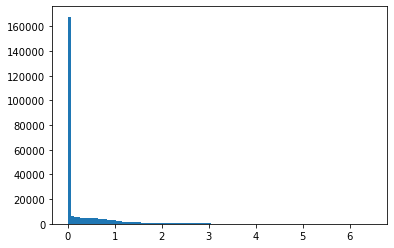

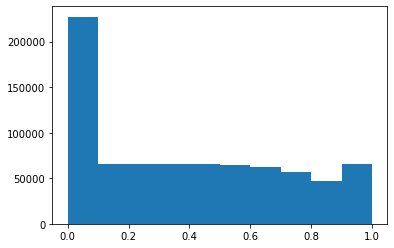

In [83]:
plt.hist(VG.opacities.tolist(), bins=100)
plt.show()
plt.hist(VG.colors.flatten().tolist())
plt.show()




In [142]:
class VoxelGrid_dev(VoxelGrid):
    def render_large_image_from_rays(self, im_rays, kwargs, batch_size=1000):
        with torch.no_grad():
            disp_im_w = im_rays[0].shape[0]
            ori = torch.tensor(im_rays[0], dtype=torch.float32, device=device).view((disp_im_w*disp_im_w,3))
            direct = torch.tensor(im_rays[1], dtype=torch.float32, device=device).view((disp_im_w*disp_im_w,3))

            out_img = torch.zeros((disp_im_w*disp_im_w,3))
            ind=0

            for ori_it, direct_it in zip(tqdm(ori.split(batch_size)), direct.split(batch_size)):
                out_img[batch_size*ind:batch_size*(ind+1)] = self.render_rays((ori_it,direct_it),*kwargs).detach()
                ind+=1

            return out_img.view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

    def save_pointcloud(self, tresh=0, filename="test.ply"):
        
        #palette = []
        #TODO: add unfold_array
        #in_palette, colors = self.make_palette(50)
        
        valid_ind = (self.opacities!=0).nonzero()
        
        j = torch.div(valid_ind, self.size, rounding_mode='floor')
        k = torch.div(j, self.size, rounding_mode='floor')


        cloud = torch.cat((valid_ind%self.size, 
                           j%self.size, 
                           k%self.size),1)/self.size
        write_ply(filename,
                  (cloud.cpu().detach().numpy(),
                   self.colors[valid_ind.flatten()].cpu().detach().numpy(), 
                   self.opacities[valid_ind.flatten()].cpu().detach().numpy()
                  ), ['x', 'y', 'z', 'r', 'g','b', 'opacity'])


In [143]:
VG2 = VoxelGrid_dev()
VG2.load('64_best.obj')
#VG2.treshold_opacity(0.9)
VG2.save_pointcloud()


wrong number of field names


In [133]:
m = torch.rand(100)>0.8
m

tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
         True, False, False, False, False, False,  True, False, False, False,
         True, False,  True, False, False,  True, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False,  True, False])

In [137]:
m = m.nonzero().flatten()
m
torch.div(m, 5, rounding_mode='floor')

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [45]:
plt.imshow(VG2.render_image_from_rays(disp_rays[0],(100, 1.2)))

RuntimeError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 7.77 GiB total capacity; 6.58 GiB already allocated; 38.69 MiB free; 6.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

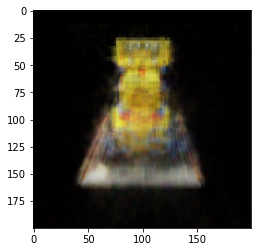

In [95]:
plt.imshow(VG.render_image_from_rays(disp_rays[0],(1000, 1.2)))

In [28]:
VG2.save_magica_vox(0.4)
#VG.save('.obj')

100%|███████████████████████████████████████████| 64/64 [00:25<00:00,  2.51it/s]


In [26]:
c = VG2.make_palette(16)

ValueError: Image RGB array must be uint8 or floating point; found int64

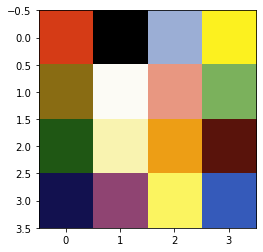

In [27]:
plt.imshow(c[1][:,:3].reshape((4,4,3)))

#plt.imsave('exporsts/64_best_palette.png', c[1][:,:3].reshape((4,4,3)))

In [22]:
all_c2w[image_ind]

disp_rays[image_ind][0][0,:,0]**2

array([8.33201508, 6.31625955, 1.60172607])

# TEST

In [10]:
VG2 = VoxelGrid()
VG2.load('64_best.obj')
VG2.bound_w

1.2

In [22]:
len(disp_ims_test)

200

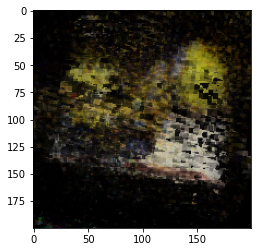

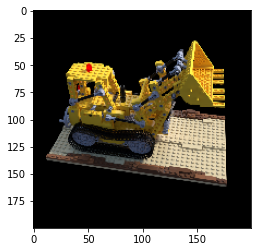

In [37]:
image_ind=28
tensor_rays_img = torch.tensor(disp_rays_test[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((disp_im_w*disp_im_w,N_points,3))

new_im = VG2.render_rays(tensor_rays_img).view((disp_im_w,disp_im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)
plt.show()
plt.imshow(disp_ims_test[image_ind])

# ROTATION

In [11]:
rays_or_dir = [get_rays_np(800,800, focal, c2w) for c2w in all_c2w]

In [12]:
camera_centers = get_cameras_centers(rays_or_dir)

[3.8 0.  1. ]


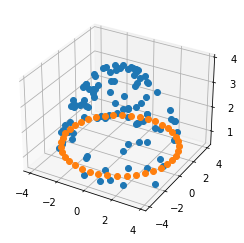

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:, 1], camera_centers[:,2], 'o')

n = 40
t = np.linspace(0,2*np.pi, n+1)[:-1]
cust_centers = np.zeros((n,3))
cust_centers[:,0] = np.cos(t)*3.8
cust_centers[:,1] = np.sin(t)*3.8
cust_centers[:,2] = 1

cust_c2ws = [create_rotation_transformation_matrix(cust_centers[i], t[i], -np.pi*0.1) for i in range(n)]

ax.plot( cust_centers[:,0], cust_centers[:,1], cust_centers[:,2], 'o')

print(cust_centers[0])



In [12]:
cust_c2ws = create_rotation_matrices(1,-10, n=40)

In [18]:
red_fac=1
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))



100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 544.38it/s]


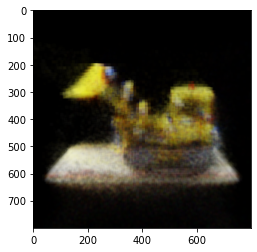

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.43it/s]


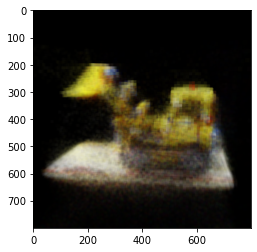

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.82it/s]


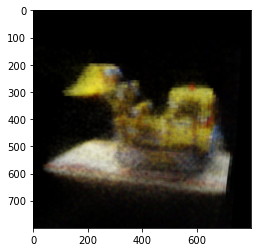

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.07it/s]


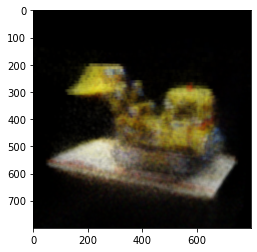

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.16it/s]


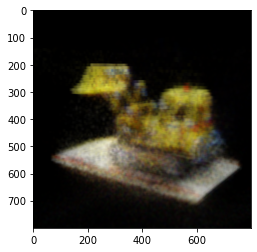

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.52it/s]


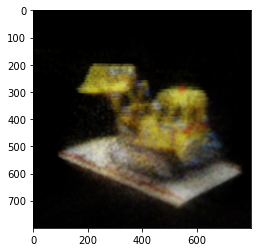

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.31it/s]


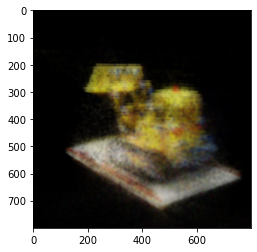

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 554.34it/s]


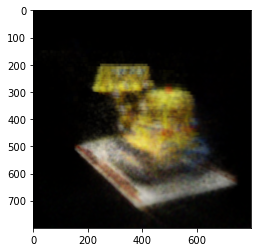

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 554.83it/s]


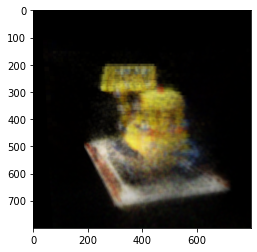

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 554.39it/s]


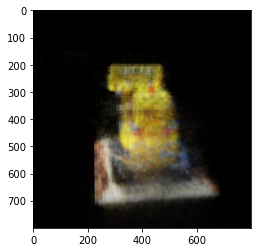

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 544.98it/s]


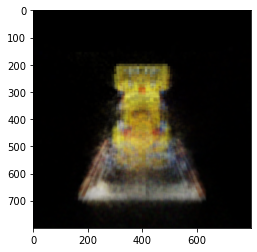

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.59it/s]


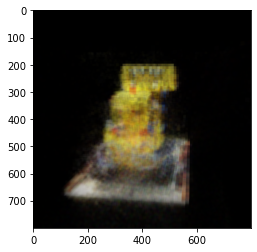

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 554.49it/s]


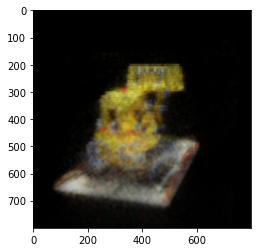

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 554.17it/s]


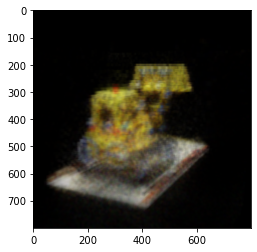

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.17it/s]


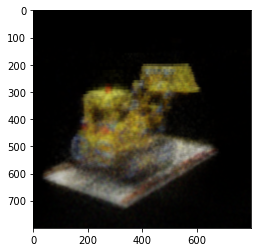

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.49it/s]


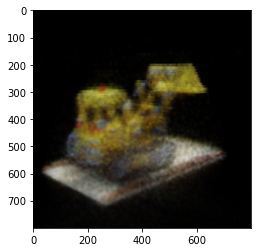

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.79it/s]


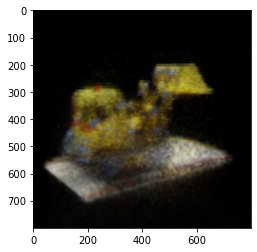

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.04it/s]


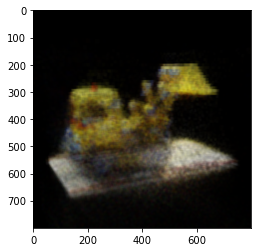

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.29it/s]


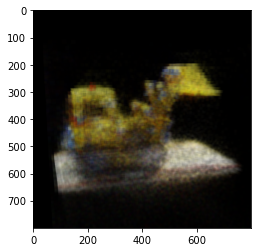

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.49it/s]


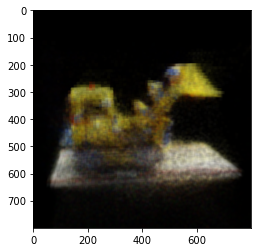

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.85it/s]


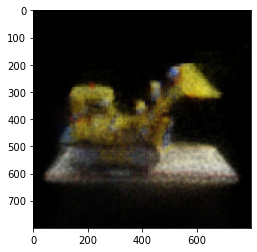

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.68it/s]


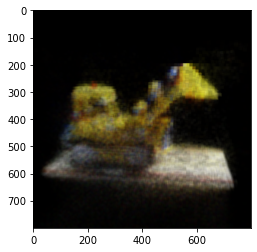

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.85it/s]


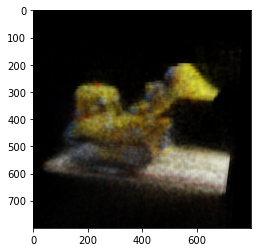

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.76it/s]


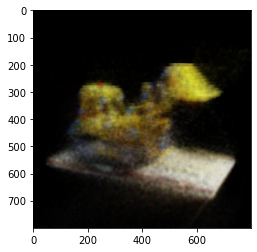

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.50it/s]


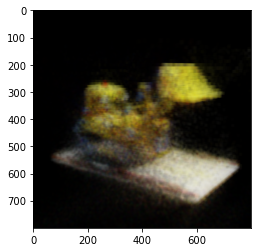

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 552.94it/s]


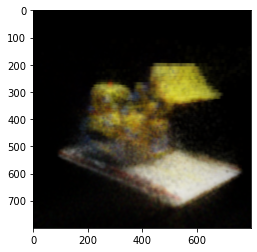

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.89it/s]


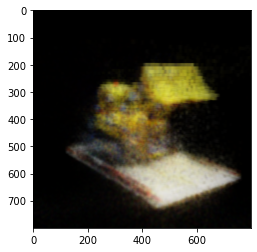

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.37it/s]


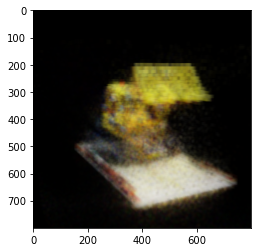

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.58it/s]


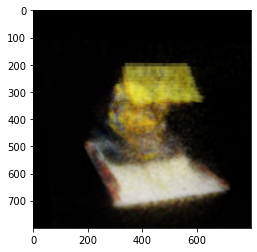

100%|██████████████████████████████████████| 1280/1280 [00:02<00:00, 553.58it/s]


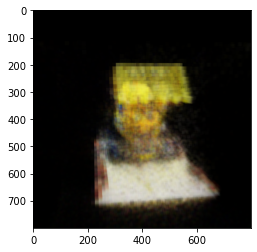

 40%|███████████████▍                       | 506/1280 [00:00<00:01, 550.30it/s]


KeyboardInterrupt: 

In [19]:
for image_ind in (range(len(cust_c2ws))):
        new_im = VG2.render_image_from_rays(ordir_rays[image_ind],(1000, 1.2), 500)
        plt.imshow(new_im)
        plt.show()

In [12]:
L=[]
k=0
i=0
while i<39:
    k+=1
    for _ in range(4):
        L.append(i)
        i+=k
L

[0, 1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 36]

In [13]:

images=[]
for ind in tqdm(L):
    VG.load('64a_'+str(ind)+'.obj')
    for image_ind in (range(len(cust_c2ws))):
        new_im = VG.render_image_from_rays(ordir_rays[image_ind], (1000, 2))
        img = Image.fromarray(np.uint8(255*new_im))
        draw = ImageDraw.Draw(img)
        draw.text((10, 10),"Epoch:"+str(ind),(255,255,255))
        images.append(np.array(img))
        #plt.imshow(images[-1])
        #plt.show()
        #images.append(np.uint8(255*new_im))
        plt.imsave('screenshots/rotate/'+str(ind)+'_'+str(image_ind)+'.png', new_im)


100%|███████████████████████████████████████████| 16/16 [00:50<00:00,  3.17s/it]


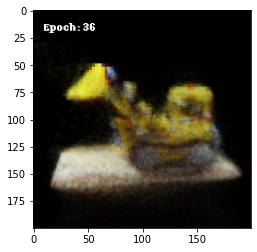

In [20]:
plt.imshow(images[-1])

In [19]:
imageio.mimwrite('screenshots/movies.gif', images,  format='GIF', duration=0.1)